<a href="https://colab.research.google.com/github/Shivam2Goyal/Network-Intrusion-Detector/blob/main/NID_using_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
import random


In [ ]:
# Define dataset URLs and file names
kdd_url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
kdd_file = "kddcup.data_10_percent.gz"

nsl_train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt"
nsl_test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"

nsl_train_file = "KDDTrain+.txt"
nsl_test_file = "KDDTest+.txt"

# Download datasets if they do not exist locally
if not os.path.exists(kdd_file):
    print("Downloading KDD Cup 10% dataset...")
    urlretrieve(kdd_url, kdd_file)

if not os.path.exists(nsl_train_file):
    print("Downloading NSL-KDD training dataset...")
    urlretrieve(nsl_train_url, nsl_train_file)

if not os.path.exists(nsl_test_file):
    print("Downloading NSL-KDD testing dataset...")
    urlretrieve(nsl_test_url, nsl_test_file)


In [ ]:
# Define column names for the dataset
kdd_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]

# Load KDD dataset into a Pandas DataFrame
kdd_data = pd.read_csv(kdd_file, names=kdd_columns)

# Drop known redundant features
drop_cols = ["num_outbound_cmds"]  # This feature is known to be constant and provides no value
kdd_data.drop(drop_cols, axis=1, inplace=True)

# Convert categorical columns to numerical using One-Hot Encoding
categorical_cols = ["protocol_type", "service", "flag"]
kdd_data = pd.get_dummies(kdd_data, columns=categorical_cols, drop_first=True)

# Convert attack labels into binary values (0 for normal, 1 for attack)
kdd_data["label"] = kdd_data["label"].apply(lambda x: 0 if x == "normal." else 1)

# Normalize numerical features using StandardScaler
scaler = StandardScaler()
numerical_cols = [col for col in kdd_data.columns if col != "label"]
kdd_data[numerical_cols] = scaler.fit_transform(kdd_data[numerical_cols])

# Split data into training and testing sets
X_kdd = kdd_data.drop("label", axis=1)  # Features
y_kdd = kdd_data["label"]  # Labels

X_train_kdd, X_test_kdd, y_train_kdd, y_test_kdd = train_test_split(
    X_kdd, y_kdd, test_size=0.2, random_state=42
)


In [ ]:
nsl_columns = kdd_columns + ["difficulty"]

nsl_train = pd.read_csv(nsl_train_file, names=nsl_columns)
nsl_test = pd.read_csv(nsl_test_file, names=nsl_columns)

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Convert categorical columns
for col in ["protocol_type", "service", "flag"]:
    nsl_train[col] = encoder.fit_transform(nsl_train[col])
    nsl_test[col] = encoder.transform(nsl_test[col])


# Map labels to binary
nsl_train["label"] = nsl_train["label"].apply(lambda x: 0 if x == "normal" else 1)
nsl_test["label"] = nsl_test["label"].apply(lambda x: 0 if x == "normal" else 1)

# Drop difficulty level column
nsl_train.drop(["difficulty"], axis=1, inplace=True)
nsl_test.drop(["difficulty"], axis=1, inplace=True)

# Separate features and labels
X_train_nsl = nsl_train.drop("label", axis=1)
y_train_nsl = nsl_train["label"]
X_test_nsl = nsl_test.drop("label", axis=1)
y_test_nsl = nsl_test["label"]

# Standardize data
X_train_nsl = scaler.fit_transform(X_train_nsl)
X_test_nsl = scaler.transform(X_test_nsl)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

class RandomForestScratch:
    def __init__(self, n_trees=10, max_features="sqrt"):
        self.n_trees = n_trees
        self.max_features = max_features
        self.trees = []

    def bootstrap_sample(self, X, y):
        # Indent the code inside the function
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)

        # Convert to NumPy arrays if they are DataFrames
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        return X[indices], y[indices]  # Standard NumPy-style indexing


    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree = DecisionTreeClassifier(max_features=self.max_features)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.round(np.mean(tree_preds, axis=0))

In [ ]:
# Train custom Random Forest
rf_scratch = RandomForestScratch(n_trees=10)
rf_scratch.fit(X_train_kdd, y_train_kdd)
y_pred_kdd_scratch = rf_scratch.predict(X_test_kdd)

# Train sklearn Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_sklearn = RandomForestClassifier(n_estimators=10)
rf_sklearn.fit(X_train_kdd, y_train_kdd)
y_pred_kdd_sklearn = rf_sklearn.predict(X_test_kdd)


Random Forest (Scratch) - KDD Performance:
Accuracy: 0.9997
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998


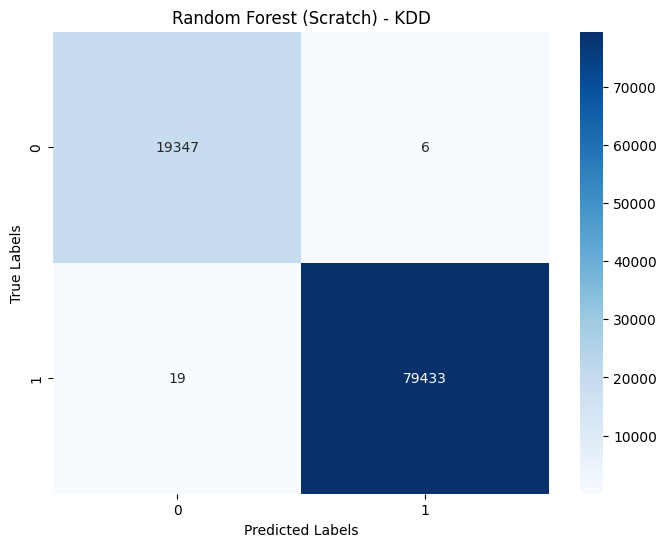

Random Forest (Sklearn) - KDD Performance:
Accuracy: 0.9996
Precision: 0.9999
Recall: 0.9996
F1 Score: 0.9998


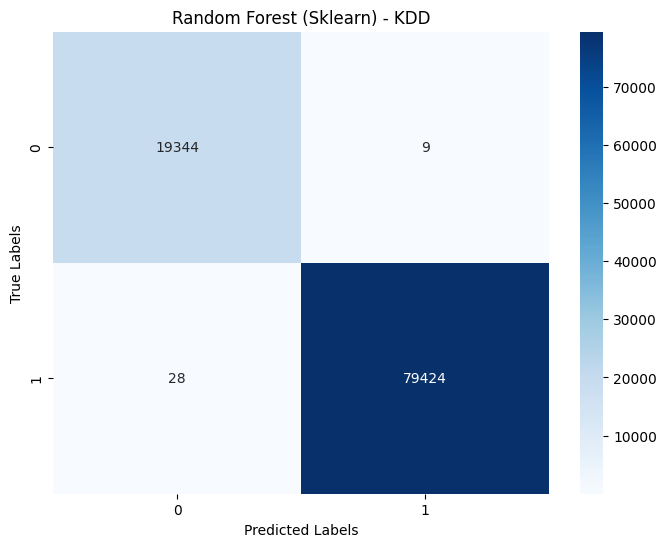

In [ ]:
def evaluate(y_true, y_pred, title):
    print(f"{title} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    plot_confusion_matrix(y_true, y_pred, title)

evaluate(y_test_kdd, y_pred_kdd_scratch, "Random Forest (Scratch) - KDD")
evaluate(y_test_kdd, y_pred_kdd_sklearn, "Random Forest (Sklearn) - KDD")


Random Forest (Scratch) - NSL Performance:
Accuracy: 0.7870
Precision: 0.9693
Recall: 0.6464
F1 Score: 0.7756


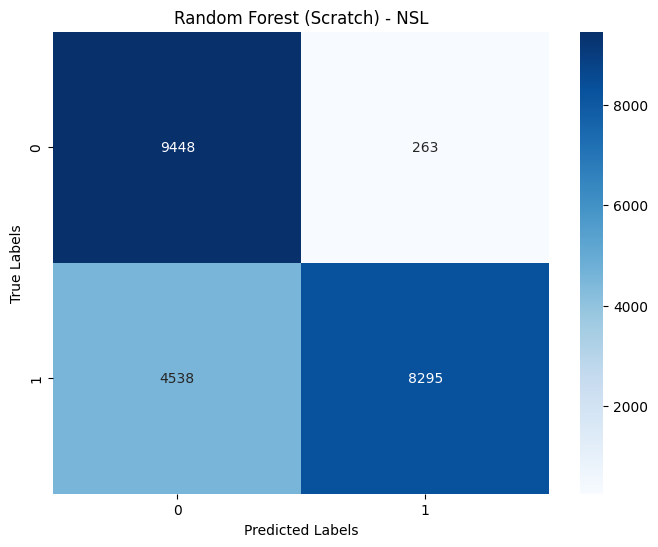

Random Forest (Sklearn) - NSL Performance:
Accuracy: 0.7768
Precision: 0.9699
Recall: 0.6274
F1 Score: 0.7619


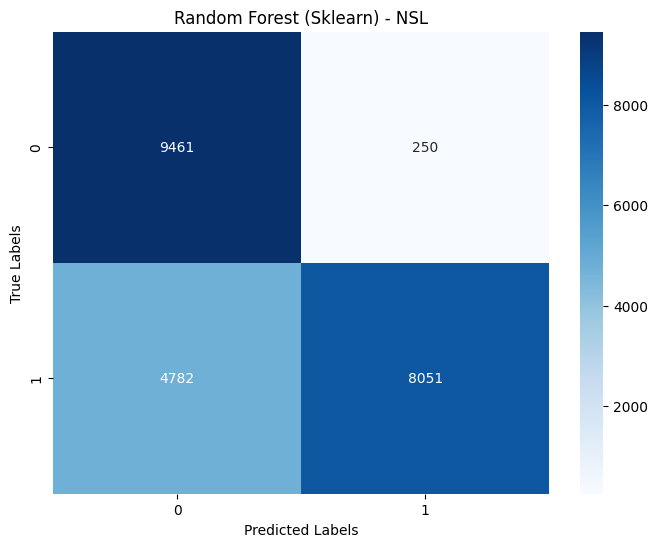

In [ ]:
# Train custom Random Forest
rf_scratch = RandomForestScratch(n_trees=10)
rf_scratch.fit(X_train_nsl, y_train_nsl)
y_pred_nsl_scratch = rf_scratch.predict(X_test_nsl)

# Train sklearn Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_sklearn = RandomForestClassifier(n_estimators=10)
rf_sklearn.fit(X_train_nsl, y_train_nsl)
y_pred_nsl_sklearn = rf_sklearn.predict(X_test_nsl)


evaluate(y_test_nsl, y_pred_nsl_scratch, "Random Forest (Scratch) - NSL")
evaluate(y_test_nsl, y_pred_nsl_sklearn, "Random Forest (Sklearn) - NSL")